# Problem Statement:

###  This is to predict the number of positive and negative reviews based on sentiments by using different classification models.

## 1. Import necessary libraries

In [277]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from collections import Counter
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## 2. Import the training dataset

In [278]:
# Download and load data from location 
imdb_data = pd.read_csv("../IMDB Dataset.csv") 
print(imdb_data.shape)
imdb_data.head()  

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# 3. Exploratory Data Analysis (EDA) 
### To analyze and investigate data sets and summarize their main characteristics by employing data visualization methods.

### (a) Obtaining data set information 

In [279]:
#Summary of the dataset
imdb_data.info()

#sentiment count
imdb_data['sentiment'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


positive    25000
negative    25000
Name: sentiment, dtype: int64

### (b) Handling Null Values

In [280]:
imdb_data.isna().any()

review       False
sentiment    False
dtype: bool

In [281]:
imdb_data.isna().sum()

review       0
sentiment    0
dtype: int64

### (c) Handling Duplicate Values 

In [282]:
imdb_data['review'].nunique()

49582

In [283]:
# let's see duplicated reviews if any before preprocessing
duplicated_count = imdb_data.duplicated().sum()
print("Number of duplicate entries: ", duplicated_count)

Number of duplicate entries:  418


In [284]:
imdb_data['review'].drop_duplicates(inplace = True)

In [285]:
imdb_data['review'].nunique()

49582

In [286]:
imdb_data.shape

(50000, 2)

### (d) Visualizing the Class Distribution

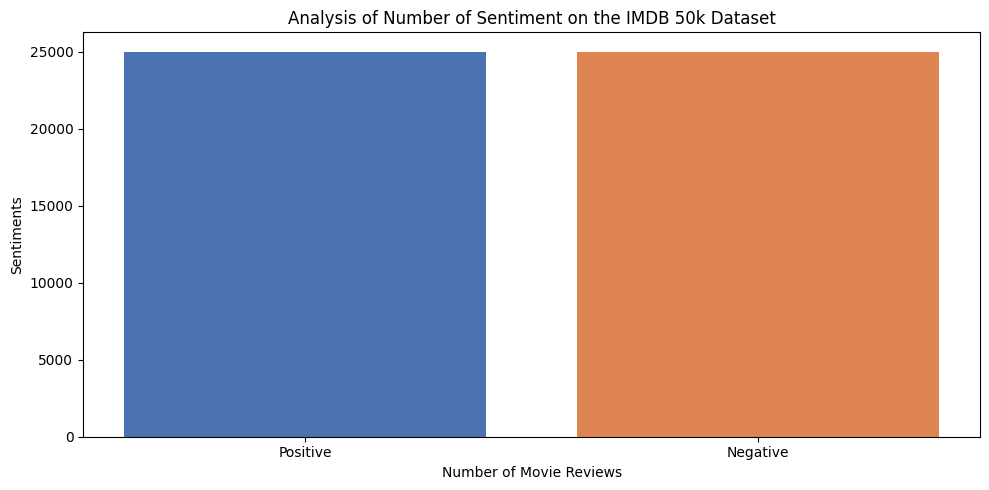

In [287]:
# Dataset information 

colors = sns.color_palette('deep')

plt.figure(figsize=(10,5), tight_layout=True)
plt.bar(x=['Positive', 'Negative'],
        height=imdb_data.value_counts(['sentiment']),
        color=colors[:2])
plt.title('Analysis of Number of Sentiment on the IMDB 50k Dataset')
plt.xlabel('Number of Movie Reviews')
plt.ylabel('Sentiments')
plt.savefig('sentiment.png')
plt.show()


### (e) Obtaining a more detailed information from the data set reviews 

In [288]:
# print the first 5 reviews

for i in range(5):
  print("Review number ",[i],"\n")
  print(imdb_data['review'].iloc[i], "\n")
  print("Sentiment: ", df['sentiment'].iloc[i], "\n\n")

Review number  [0] 

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the s

### (f) Investigating the number of words in each reviews

In [289]:
# Defining a function to count number of words in each review

def count_words(text):
  words = text.split()
  num_words = len(words)
  return num_words

# To view the new table including word count

imdb_data['word count'] = imdb_data['review'].apply(count_words)
imdb_data.head()

,review,sentiment,word count
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


### (e) Visualizing the distribution of word count 

Text(0.5, 1.0, 'Distrbution of negative reviews')

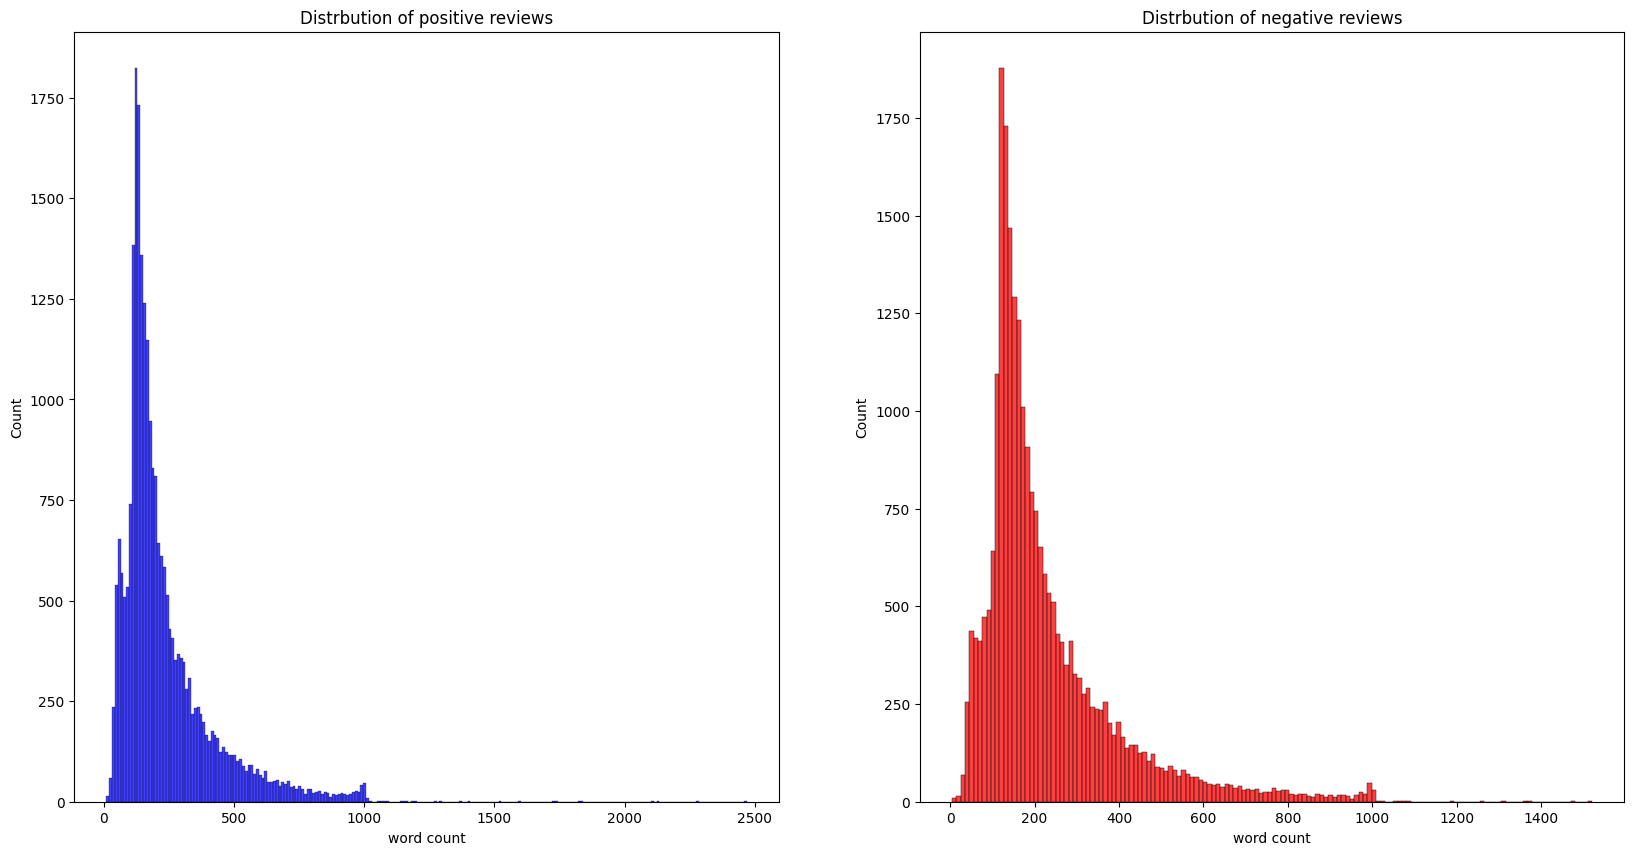

In [290]:
# let's see the number of words for each sentiment
fig, ax = plt.subplots(1,2, figsize=(20,10))
sns.histplot(imdb_data[imdb_data['sentiment'] == 'positive']['word count'], ax=ax[0], color='blue')
ax[0].set_title('Distrbution of positive reviews')
sns.histplot(imdb_data[imdb_data['sentiment'] == 'negative']['word count'], ax=ax[1], color='red')
ax[1].set_title('Distrbution of negative reviews')

In [186]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\apple\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\apple\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 4. Data Preprocessing

### Data Cleaning: 
#### The data cleaning step involves removing any irrelevant information, fixing any formatting issues, handling missing data, and correcting any spelling or grammatical errors in the data. In this dataset, the data cleaning step might involve removing HTML tags, removing stopwords, and stemming or lemmatizing the words.

### Tokenization: 
#### The tokenization step involves breaking down the text into individual words or tokens. This step is important for analyzing the text as it allows us to work with individual words rather than entire sentences.

### Stopword Removal: 
#### Stopwords are common words that occur frequently in a language, such as "the", "a", "an", etc. They do not add any value to the analysis, so they are usually removed from the text.

### Stemming/Lemmatization: 
#### Stemming and lemmatization are techniques used to reduce words to their base form. Stemming involves removing the suffixes of words to reduce them to their stem, while lemmatization involves reducing words to their base form using a dictionary.

In [291]:
# defining the function to clean the reviews

def preprocess(text):
  soup = BeautifulSoup(text, "html.parser") #Removing the html strips
  text = soup.get_text()
  text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
  text = re.sub(r'[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*', "", text, flags = re.MULTILINE)  #Removing emails 
  text = re.sub('\[[^]]*\]', '', text)  #Removing the square brackets
  text = re.sub(r'[^a-zA-z0-9\s]', '', text)  #Removing special character and keep only words and numbers
  text_tokens = word_tokenize(text)
  filtered_text = [w for w in text_tokens if not w in stop_words]  #Removing stop words
  new_text = " ".join(filtered_text)
  ps = nltk.porter.PorterStemmer()  #Stemming the text
  new_text = ' '.join([ps.stem(word) for word in new_text.split()])
  return new_text

In [292]:
# let's see duplicated reviews before preprocessing
duplicated_count = imdb_data.duplicated().sum()
print("Number of duplicate entries: ", duplicated_count)

Number of duplicate entries:  418


In [293]:
# let's apply it on reviews
imdb_data.review = imdb_data['review'].apply(preprocess)

In [294]:
# Let's check duplicated reviews after preprocessing
duplicated_count = imdb_data.duplicated().sum()
print("Number of duplicate entries: ", duplicated_count)

Number of duplicate entries:  420


In [295]:
# let's drop all duplicated reviews
imdb_data = imdb_data.drop_duplicates('review')

In [306]:
# encoding the sentiment
imdb_data.sentiment.replace("positive", 1, inplace=True)
imdb_data.sentiment.replace("negative", 0, inplace=True)

In [307]:
# let's count the words in each review again
imdb_data['new word count'] = imdb_data['review'].apply(count_words)

In [308]:
imdb_data.head()

,review,sentiment,word count,new word count
0,one review mention watch 1 oz episod youll hoo...,1,307,179
1,a wonder littl product the film techniqu unass...,1,162,91
2,i thought wonder way spend time hot summer wee...,1,166,92
3,basic there famili littl boy jake think there ...,0,138,71
4,petter mattei love time money visual stun film...,1,230,130


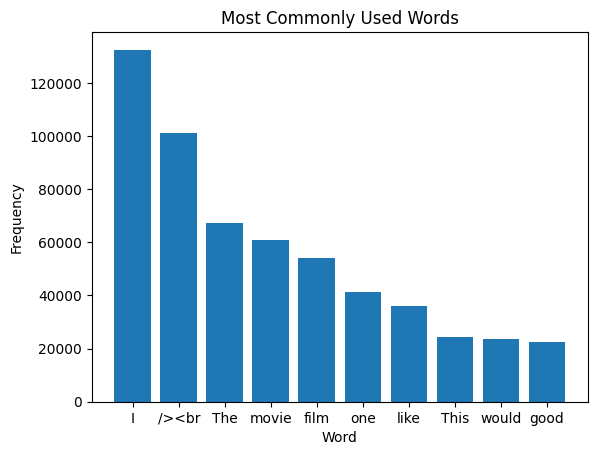

In [309]:
# Create a bar chart of the most common words
top_words = word_counts.most_common(10) # Change the number to show more/less words
x_values = [word[0] for word in top_words]
y_values = [word[1] for word in top_words]
plt.bar(x_values, y_values)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words')
plt.show()

In [311]:
#print ten word cloud for positive review words
pos_reviews =  imdb_data[imdb_data.sentiment == 1]
pos_reviews.head(10)

,review,sentiment,word count,new word count
0,one review mention watch 1 oz episod youll hoo...,1,307,179
1,a wonder littl product the film techniqu unass...,1,162,91
2,i thought wonder way spend time hot summer wee...,1,166,92
4,petter mattei love time money visual stun film...,1,230,130
5,probabl alltim favorit movi stori selfless sac...,1,119,63
6,i sure would like see resurrect date seahunt s...,1,150,80
9,if like origin gut wrench laughter like movi i...,1,33,19
14,thi fantast movi three prison becom famou one ...,1,50,30
16,some film simpli remad thi one in bad film but...,1,146,62
18,i rememb filmit first film watch cinema pictur...,1,129,68


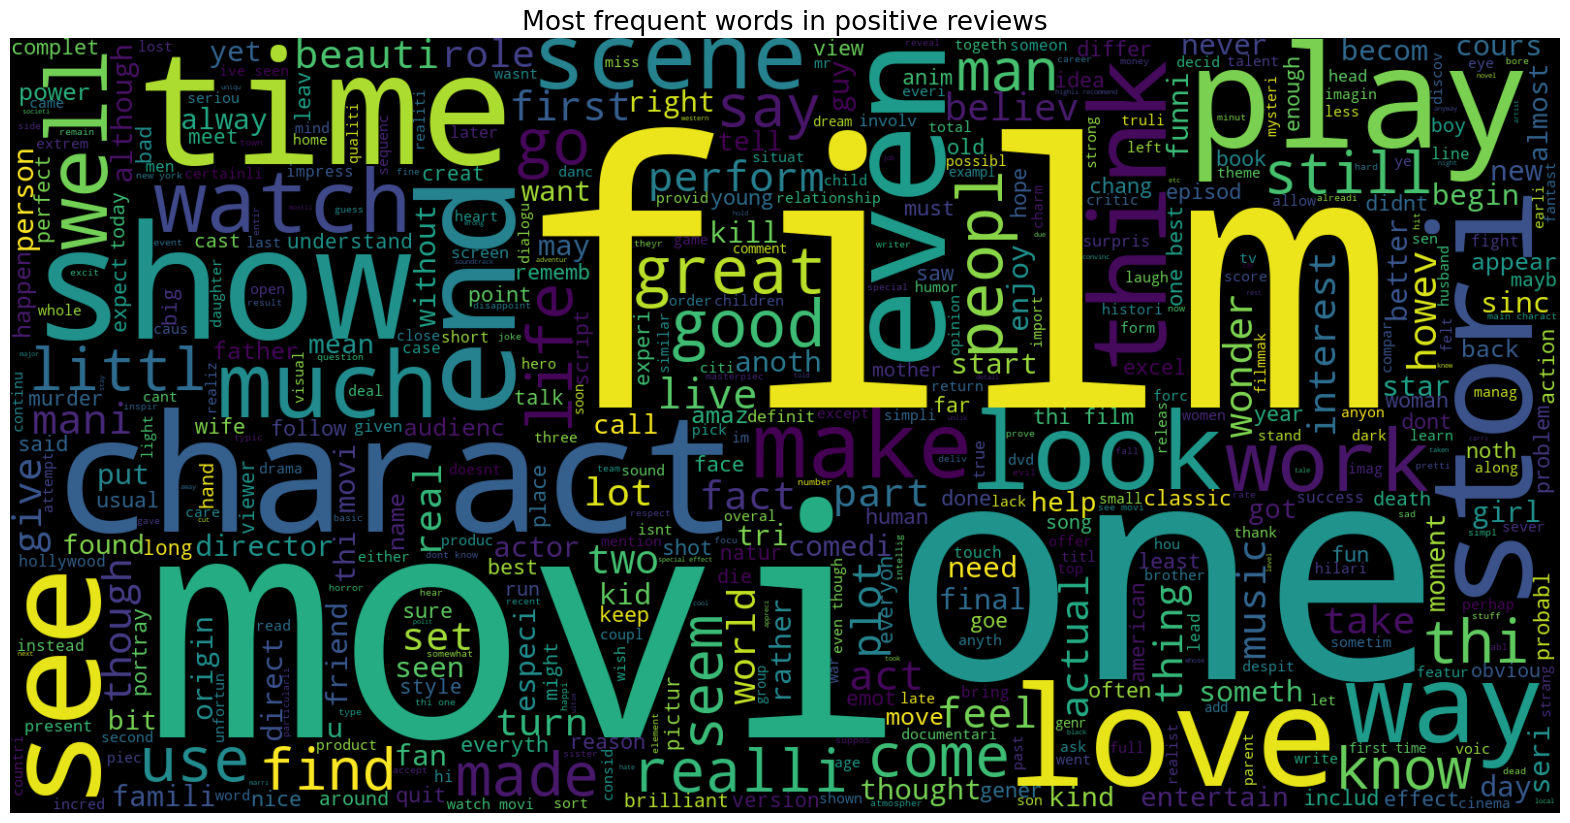

In [312]:
# To Create a word cloud that represent the most common words in positive reviews

text = ' '.join([word for word in pos_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in positive reviews', fontsize = 19)
plt.show()

In [314]:
# print the most common words in positive review and their frequency 
from collections import Counter
count = Counter()
for text in pos_reviews['review'].values:
    for word in text.split():
        count[word] +=1
count.most_common()

[('i', 63690),
 ('film', 48837),
 ('movi', 42885),
 ('the', 38708),
 ('one', 26834),
 ('like', 19810),
 ('it', 17898),
 ('time', 15399),
 ('see', 14624),
 ('good', 14502),
 ('stori', 13607),
 ('charact', 13559),
 ('make', 13112),
 ('thi', 12974),
 ('great', 12719),
 ('get', 12526),
 ('watch', 12424),
 ('love', 12010),
 ('well', 11257),
 ('show', 10754),
 ('realli', 10638),
 ('also', 10513),
 ('would', 10320),
 ('play', 9801),
 ('scene', 9654),
 ('even', 9603),
 ('much', 8970),
 ('first', 8821),
 ('end', 8781),
 ('peopl', 8609),
 ('way', 8476),
 ('think', 8327),
 ('best', 8281),
 ('go', 8014),
 ('he', 7909),
 ('look', 7855),
 ('mani', 7524),
 ('life', 7424),
 ('work', 7234),
 ('year', 7229),
 ('know', 7089),
 ('made', 6966),
 ('two', 6851),
 ('perform', 6821),
 ('thing', 6820),
 ('take', 6682),
 ('seen', 6573),
 ('dont', 6568),
 ('act', 6562),
 ('say', 6539),
 ('come', 6529),
 ('littl', 6368),
 ('man', 6309),
 ('still', 6295),
 ('but', 6264),
 ('never', 6243),
 ('could', 6082),
 ('seem'

In [315]:
#word cloud for negitive review words
neg_reviews =  imdb_data[imdb_data.sentiment == 0]
neg_reviews.head()

,review,sentiment,word count,new word count
3,basic there famili littl boy jake think there ...,0,138,71
7,thi show amaz fresh innov idea 70 first air th...,0,174,93
8,encourag posit comment film i look forward wat...,0,130,68
10,phil alien one quirki film humour base around ...,0,96,53
11,i saw movi i 12 came i recal scariest scene bi...,0,180,96


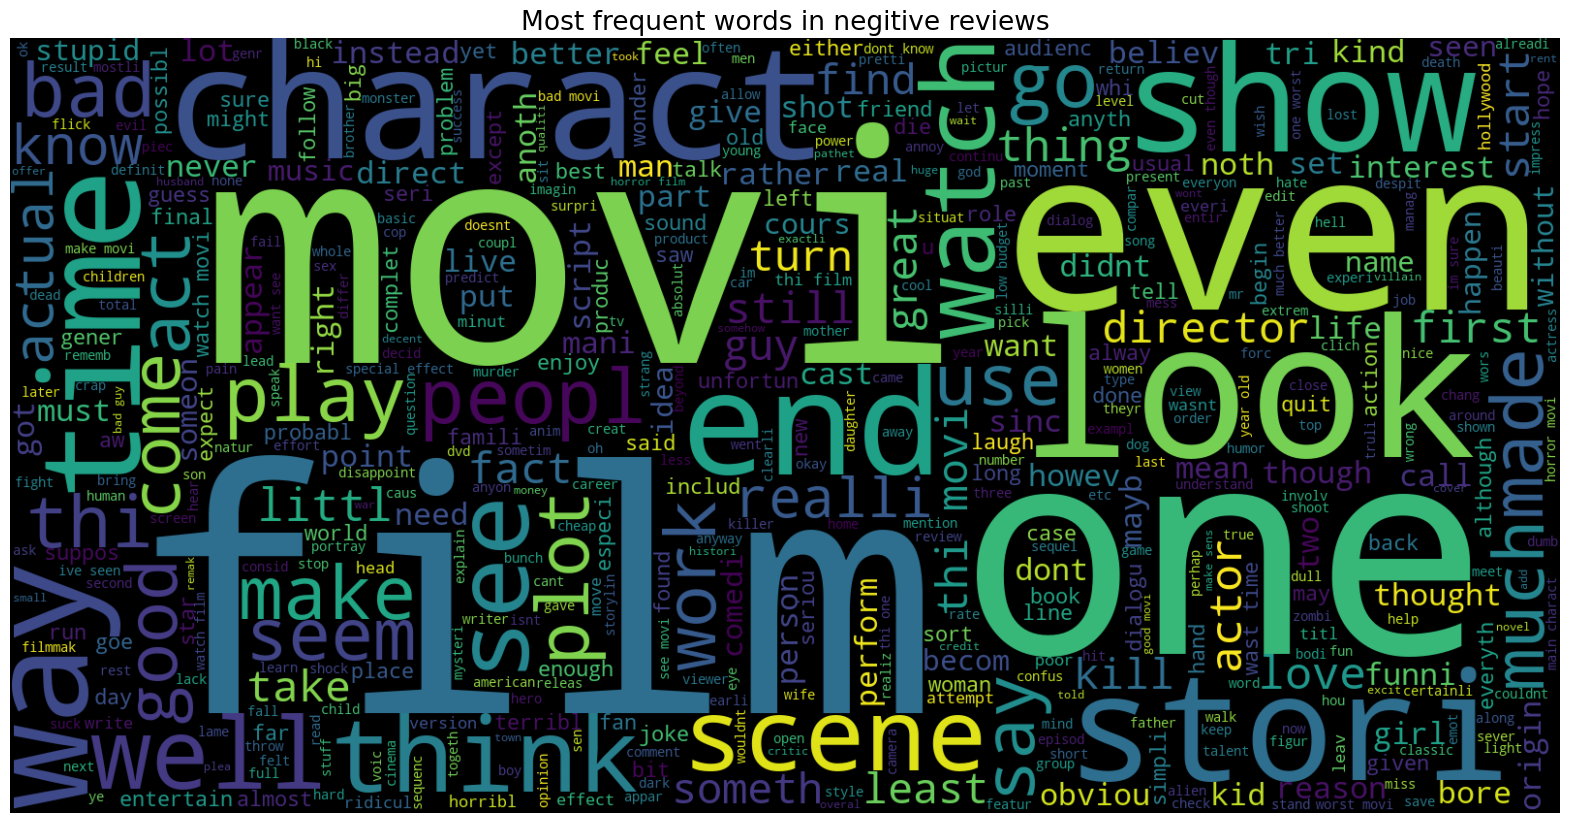

In [316]:
# To Create a word cloud that represent the most common words in negative reviews

text = ' '.join([word for word in neg_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in negitive reviews', fontsize = 19)
plt.show()

In [318]:
# print the most common words used in negative review and their frequency 
from collections import Counter
count = Counter()
for text in neg_reviews['review'].values:
    for word in text.split():
        count[word] +=1
count.most_common()

[('i', 71410),
 ('movi', 55292),
 ('film', 42590),
 ('the', 39187),
 ('one', 25415),
 ('like', 23646),
 ('it', 16299),
 ('make', 15264),
 ('get', 14969),
 ('even', 14933),
 ('watch', 14382),
 ('good', 14191),
 ('time', 14150),
 ('bad', 13964),
 ('charact', 13774),
 ('would', 13481),
 ('see', 12707),
 ('thi', 12600),
 ('realli', 12085),
 ('look', 11188),
 ('scene', 10898),
 ('stori', 10453),
 ('act', 10035),
 ('dont', 9885),
 ('much', 9759),
 ('go', 9507),
 ('end', 9218),
 ('peopl', 9214),
 ('thing', 9114),
 ('could', 8917),
 ('think', 8838),
 ('show', 8406),
 ('made', 8301),
 ('there', 8180),
 ('say', 8116),
 ('plot', 8109),
 ('way', 7900),
 ('seem', 7898),
 ('first', 7869),
 ('know', 7671),
 ('well', 7536),
 ('tri', 7427),
 ('want', 7083),
 ('play', 7061),
 ('actor', 6878),
 ('also', 6843),
 ('he', 6794),
 ('and', 6777),
 ('never', 6488),
 ('but', 6462),
 ('better', 6414),
 ('seen', 6375),
 ('come', 6321),
 ('ever', 6318),
 ('that', 6243),
 ('take', 6091),
 ('two', 5962),
 ('littl', 5

## 5. Feature Extraction


In [332]:
# The term Frequency-Inverse Document Frequency model (TFIDF) is used to convert text documents to matrix of tfidf features
vect = TfidfVectorizer()
x = vect.fit_transform(imdb_data['review'])
y = imdb_data['sentiment']

In [333]:
print("Size of x: ", (x.shape))
print("Size of y: ", (y.shape))

Size of x:  (49578, 181489)
Size of y:  (49578,)


## 6. Data Split into Training & Testing Datasets

In [334]:
# Split the dataset into 80% training and 20% testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [335]:
print("Size of x_train: ", (x_train.shape))
print("Size of y_train: ", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))


Size of x_train:  (39662, 181489)
Size of y_train:  (39662,)
Size of x_test:  (9916, 181489)
Size of y_test:  (9916,)


## 7. Machine Learning Modelling

In [336]:
# Import important libraries 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### (a) Logistic Regression

In [339]:
# LogisticRegression
lr = LogisticRegression()
lr.fit(x_train, y_train)
print("train score : ", lr.score(x_train, y_train))
print("test score : ", lr.score(x_test, y_test))
lr_pred = lr.predict(x_test)
lr_acc = accuracy_score(lr_pred, y_test)
print("Test accuracy: {:.2f}%".format(lr_acc*100))

train score :  0.9280671675659321
test score :  0.8907825736183945
Test accuracy: 89.08%


In [340]:
lr_report=classification_report(y_test,lr_pred,target_names=['Positive','Negative'])
print(lr_report)

              precision    recall  f1-score   support

    Positive       0.90      0.88      0.89      4885
    Negative       0.88      0.90      0.89      5031

    accuracy                           0.89      9916
   macro avg       0.89      0.89      0.89      9916
weighted avg       0.89      0.89      0.89      9916



In [341]:
# define a function for Confusion Matrix
def cm (y_test,y_pred):
  cm = confusion_matrix(y_test, y_pred)
  cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                  index=['Predict Positive:1', 'Predict Negative:0'])
  sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

Text(0.5, 1.0, 'Confusion matrix of Logistic Regression')

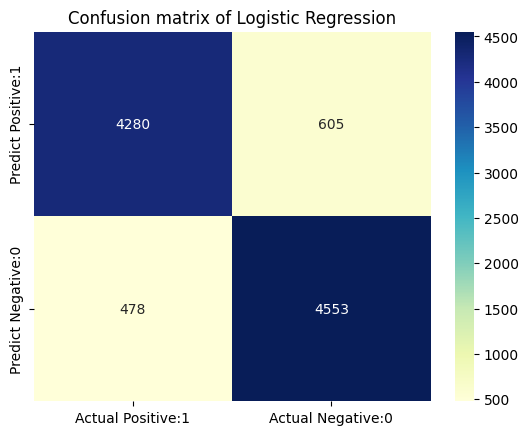

In [342]:
cm(y_test,lr_pred)
plt.title('Confusion matrix of Logistic Regression')

### (b) Linear Support Vector Machine

In [366]:
#Linear svm
lsvm = LinearSVC()
lsvm.fit(x_train, y_train)
print("train score : ", lsvm.score(x_train, y_train))
print("test score : ", lsvm.score(x_test, y_test))
lsvm_pred = lsvm.predict(x_test)
lsvm_acc = accuracy_score(lsvm_pred, y_test)
print("Test accuracy: {:.2f}%".format(lsvm_acc*100))

train score :  0.986536231153245
test score :  0.8900766438079871
Test accuracy: 89.01%


In [367]:
lsvm_report=classification_report(y_test,lsvm_pred,target_names=['Positive','Negative'])
print(lsvm_report)

              precision    recall  f1-score   support

    Positive       0.90      0.88      0.89      4885
    Negative       0.88      0.90      0.89      5031

    accuracy                           0.89      9916
   macro avg       0.89      0.89      0.89      9916
weighted avg       0.89      0.89      0.89      9916



Text(0.5, 1.0, 'Confusion matrix of LinearSVC')

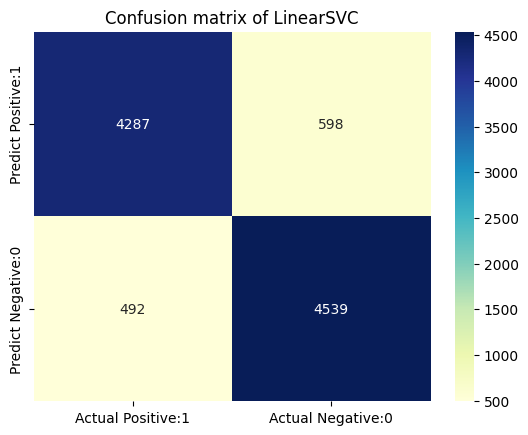

In [368]:
cm(y_test,lsvm_pred)
plt.title('Confusion matrix of LinearSVC')

### (c) Multinomial Naive Bayes Model

In [370]:
# MultinomialNB
mn = MultinomialNB()
mn.fit(x_train, y_train)
print("train score : ", mn.score(x_train, y_train))
print("test score : ", mn.score(x_test, y_test))
mn_pred = mn.predict(x_test)
mn_acc = accuracy_score(mn_pred, y_test)
print("Test accuracy: {:.2f}%".format(mn_acc*100))

train score :  0.9106197367757551
test score :  0.859318273497378
Test accuracy: 85.93%


In [371]:
mn_report=classification_report(y_test,mn_pred,target_names=['Positive','Negative'])
print(mn_report)

              precision    recall  f1-score   support

    Positive       0.85      0.87      0.86      4885
    Negative       0.87      0.85      0.86      5031

    accuracy                           0.86      9916
   macro avg       0.86      0.86      0.86      9916
weighted avg       0.86      0.86      0.86      9916



Text(0.5, 1.0, 'Confusion matrix of MultinomialNB')

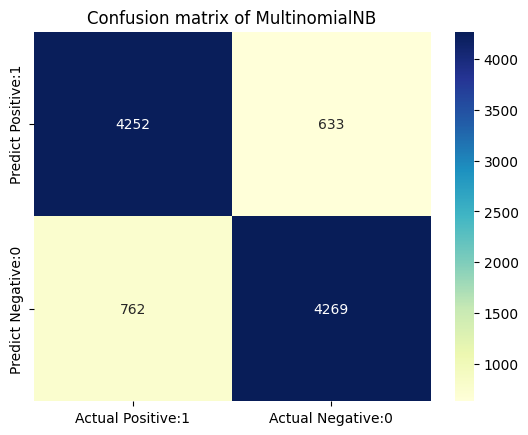

In [372]:
cm(y_test,mn_pred)
plt.title('Confusion matrix of MultinomialNB')

### (d) Decision Tree Classification 

In [373]:
# DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
print("train score : ", dt.score(x_train, y_train))
print("test score : ", dt.score(x_test, y_test))
dt_pred = dt.predict(x_test)
dt_acc = accuracy_score(dt_pred, y_test)
print("Test accuracy: {:.2f}%".format(dt_acc*100))

train score :  1.0
test score :  0.7117789431222267
Test accuracy: 71.18%


In [374]:
dt_report=classification_report(y_test,dt_pred,target_names=['Positive','Negative'])
print(dt_report)

              precision    recall  f1-score   support

    Positive       0.71      0.70      0.71      4885
    Negative       0.71      0.72      0.72      5031

    accuracy                           0.71      9916
   macro avg       0.71      0.71      0.71      9916
weighted avg       0.71      0.71      0.71      9916



Text(0.5, 1.0, 'Confusion matrix of Decision Tree')

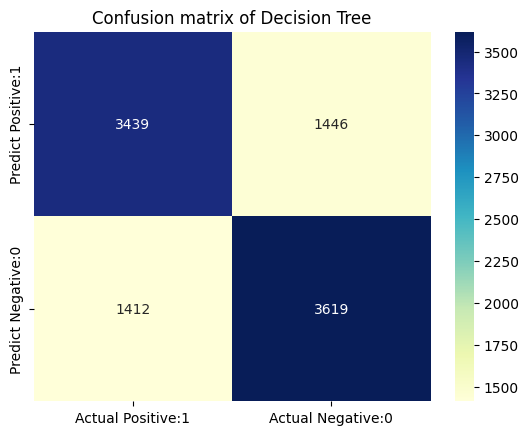

In [375]:
cm(y_test,dt_pred)
plt.title('Confusion matrix of Decision Tree')

### (e) Linear discriminant analysis

In [378]:
# linear discrimant analysis
lda = LogisticRegression(random_state = 0)
lda.fit(x_train, y_train) 
    
print("train score : ", dt.score(x_train, y_train))
print("test score : ", dt.score(x_test, y_test))
lda_pred = lda.predict(x_test)
lda_acc = accuracy_score(lda_pred, y_test)
print("Test accuracy: {:.2f}%".format(lda_acc*100))

train score :  1.0
test score :  0.7117789431222267
Test accuracy: 89.08%


In [379]:
lda_report=classification_report(y_test,lda_pred,target_names=['Positive','Negative'])
print(lda_report)

              precision    recall  f1-score   support

    Positive       0.90      0.88      0.89      4885
    Negative       0.88      0.90      0.89      5031

    accuracy                           0.89      9916
   macro avg       0.89      0.89      0.89      9916
weighted avg       0.89      0.89      0.89      9916



Text(0.5, 1.0, 'Confusion matrix of linear discriminant analysis')

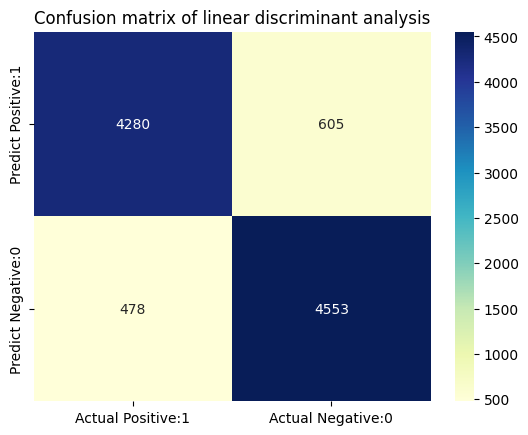

In [380]:
cm(y_test,lda_pred)
plt.title('Confusion matrix of linear discriminant analysis')